In [1]:
%load_ext autoreload
%autoreload 2

import skimage.io
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'gray'

Image size 512x512 with 3 channels


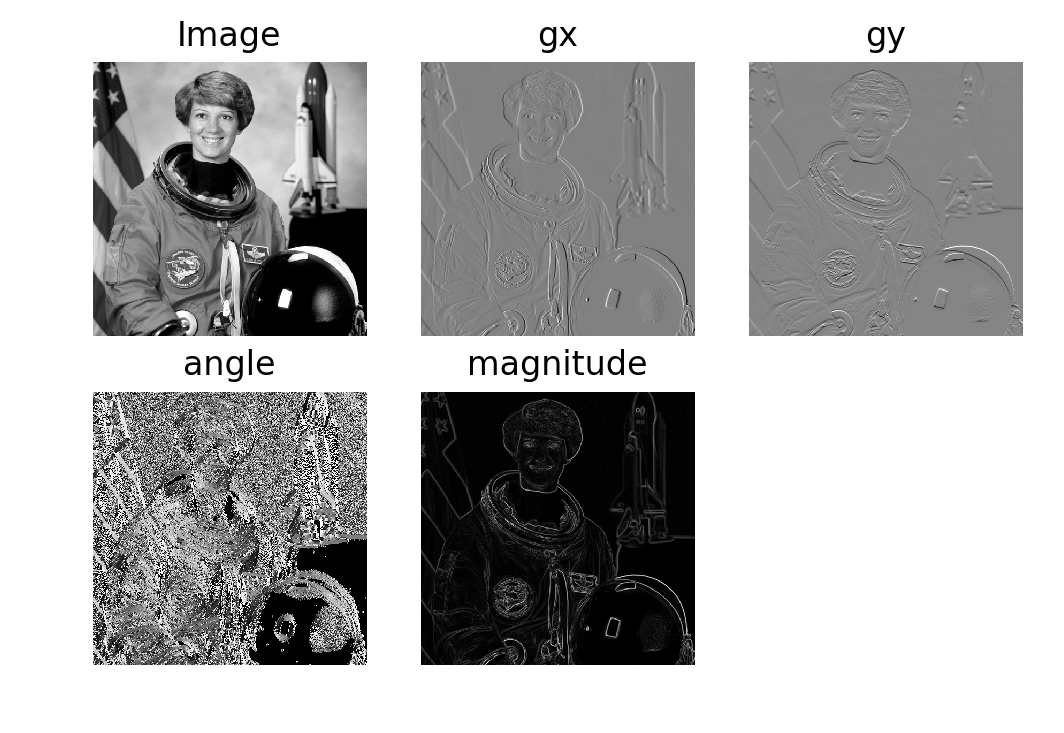

In [5]:


# # EXAMPLE 1: Image with pedestrians
# # Read an image
# image_rgb=skimage.io.imread("hog.jpg")

# # Crop the image to select a region that contains a person
# posx,posy=203,569
# crop_h,crop_w=768,256
# image_rgb=image_rgb[posx:posx+crop_h,posy:posy+crop_w,:]
# END EXAMPLE 1

# EXAMPLE 2: Image from skimage hog example (http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)
from skimage import data
image_rgb=data.astronaut()
# END EXAMPLE 2

h,w,c=image_rgb.shape
#(now image_rgb has size w*h)
print("Image size {}x{} with {} channels".format(h,w,c))

#transform the image from rgb to grayscale 
# (there are ways to get the HOG of a color image, but we'll start with grayscale)
image=np.mean(image_rgb,axis=2)

#calculate the gradient matrices, one for each direction (x (columns) and y (rows))
gy,gx=np.gradient(image)

# both gx and gy have sizes w*h
# Calculate the magnitude of the gradient of every pixel (vectorized solution)
magnitude = np.sqrt(gx**2+gy**2) # these calculations are PER pixel

# calculate the angle of each gradient (vectorized solution). 
# Alternatively, could use the arccos of gx/magnitude or arcsin of gy/magnitude.
# using arctan2 for numerical stability
angle=np.arctan2(gy,gx)

#arctan2 returns angle in range [-pi,pi]
# Since we want to consider oposite angles as the same 
#(ie, 90 is the same as 270 (or -90), and 45 is the same as 225 (or -135))
# we add pi (180°) to negative angles

angle[angle<0]=angle[angle<0]+np.pi

# both angle and magnitude matrices have sizes w*h (same as gx, gy and the image!)

f,((a1,a2,a3),(b1,b2,b3))=plt.subplots(2,3,dpi=200)
for ax in [a1,a2,a3,b1,b2,b3]:
    ax.axis("off")
    
a1.set_title("Image")
a1.imshow(image)
a2.set_title("gx")
a2.imshow(gx)
a3.set_title("gy")
a3.imshow(gy)
b1.imshow(angle)
b1.set_title("angle")
b2.imshow(magnitude)
b2.set_title("magnitude")
plt.show()




In [3]:


print("Calculating HOG cells:")

histogram_bins=8
print("Histogram with {} bins. Resulting ranges for angle discretization into bins:".format(histogram_bins))

eps=np.finfo(float).eps # really small number
bins=np.linspace(0,np.pi+eps,histogram_bins)
print(bins)

cell_h,cell_w=(16,16) # CHANGE THIS TO EXPERIMENT 
print("Cell size {}x{}".format(cell_h,cell_w))

# Check that the image can be perfectly split into cells of size cell_h x cell_w 
assert w % cell_w == 0
assert h % cell_h == 0

# calculate the number of cells, ie, the size of the cell grid
cell_rows,cell_cols=(h//cell_h,w//cell_w)
cells_n=cell_rows*cell_cols
print("Cell grid {}x{}, ".format(cell_rows,cell_cols))
print("{} cells per image, {} histogram bins -> cell grid size = {}".format(cells_n,histogram_bins,cells_n*histogram_bins))

cell_histograms=np.zeros((cell_rows,cell_cols,histogram_bins))

#calculate the histogram for each cell
for i in range(cell_rows):
    for j in range(cell_cols):
        #get the angles and magnitudes for cell i,j. 
        cell_top,cell_left=i*cell_h,j*cell_w
        
        cell_angles    =      angle[cell_top:cell_top+cell_h,cell_left:cell_left+cell_w]
        cell_magnitudes = magnitude[cell_top:cell_top+cell_h,cell_left:cell_left+cell_w]

        # convert matrices into vectors since we don't care about the 2D structure of pixels here
        
        cell_angles=np.reshape(cell_angles,-1)
        cell_magnitudes=np.reshape(cell_magnitudes,-1)
        
        #discretize angles into bin indices with the ranges in 'bins'
        indices=np.digitize(cell_angles,bins)
        # the index 0 is reserved for negative numbers, we shouldn't have any
        indices=indices-1 
        
        #the indices vector has the same size as cell_angles and cell_magnitudes
        #indices[k] tells me the bin index of the pixel that can be found
        # at cell_angles[k] and cell_magnitudes[k]
        
        #calculate the histogram for cell i,j by adding the magnitudes at the corresponding indices
        cell_histograms[i,j,indices]+=cell_magnitudes[indices]

print("done")

Calculating HOG cells:
Histogram with 8 bins. Resulting ranges for angle discretization into bins:
[ 0.          0.44879895  0.8975979   1.34639685  1.7951958   2.24399475
  2.6927937   3.14159265]
Cell size 16x16
Cell grid 32x32, 
1024 cells per image, 8 histogram bins -> cell grid size = 8192
done


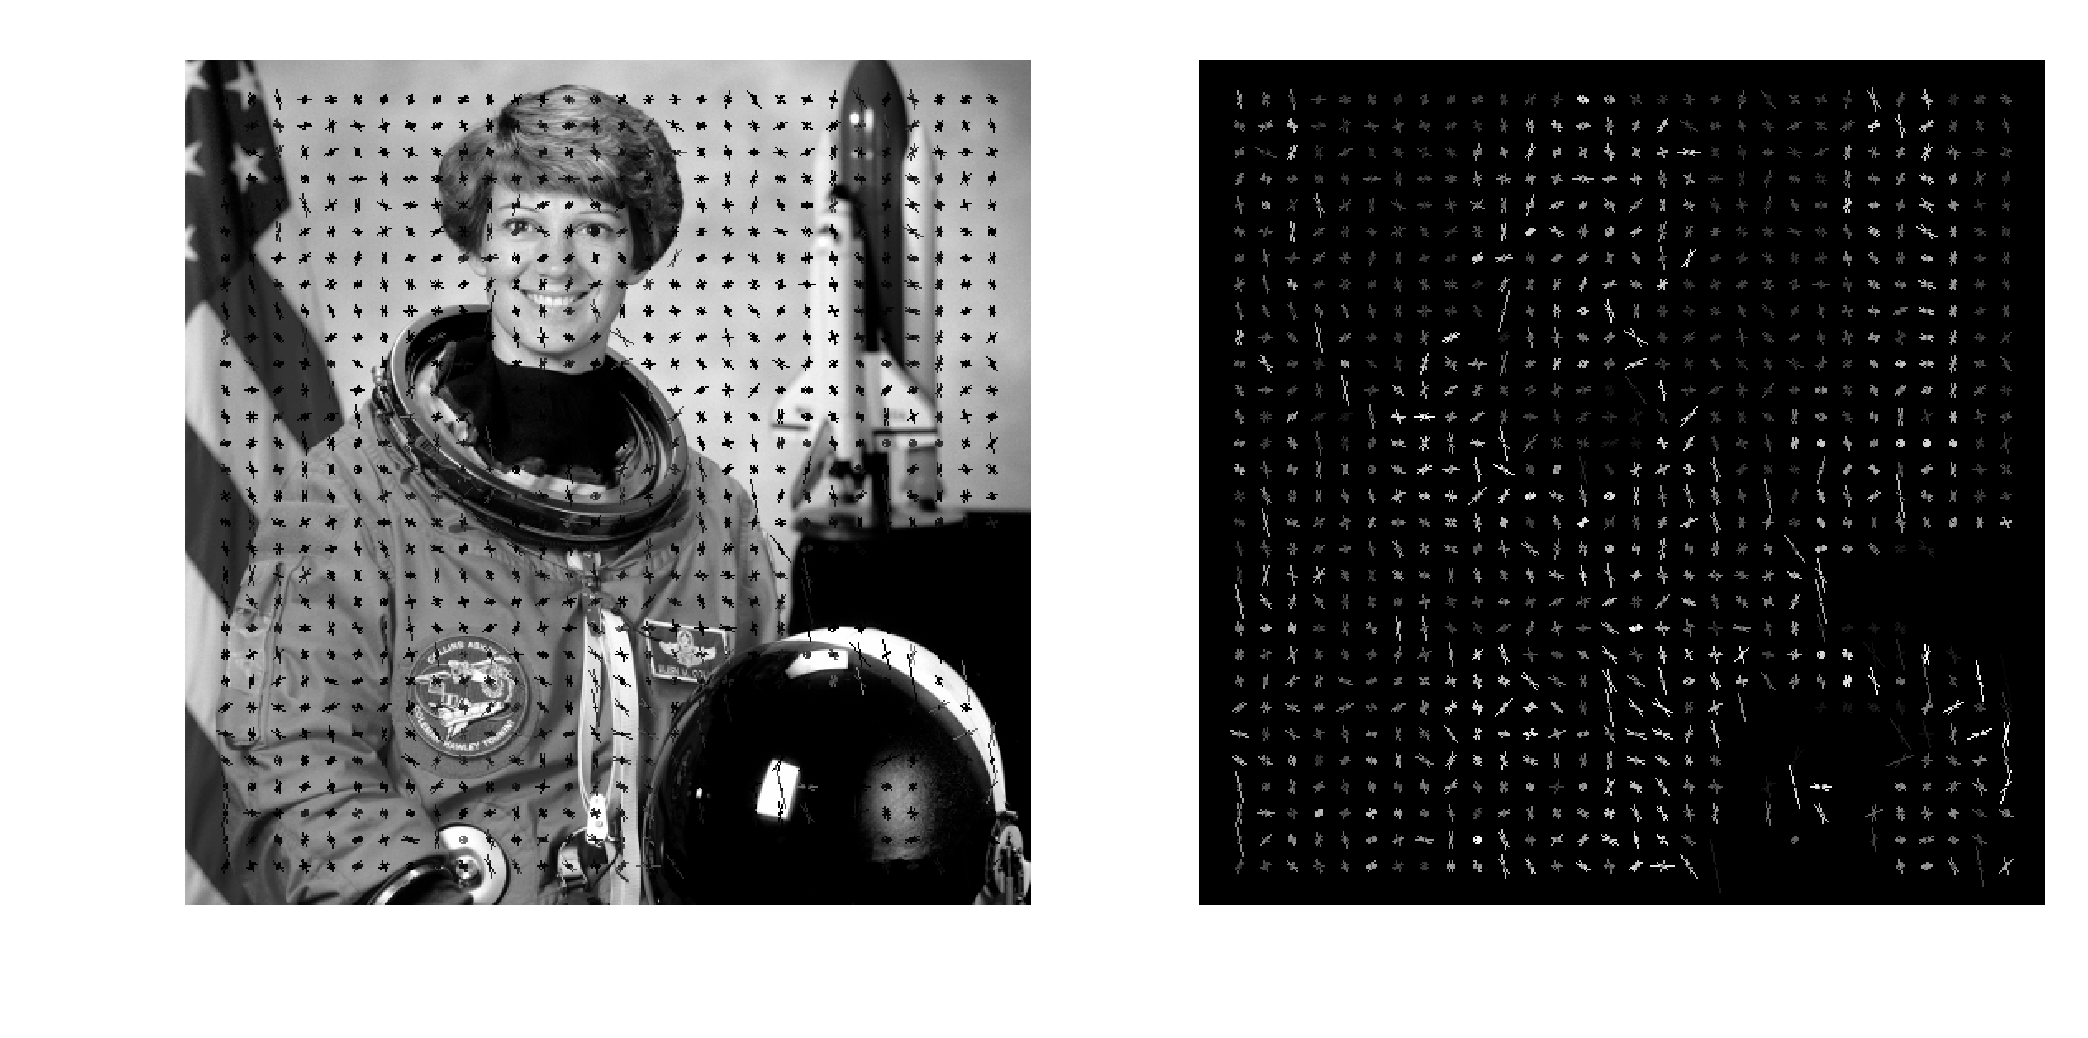

In [4]:
import copy 
import skimage.draw 

#PLOT the gradient histograms for each cell
# The gradient histogram has bins
# Each bin corresponds to a range of angles, ie, 0° to 45°
# For each cell we will plot the histogram by plotting one line for each bin
# The lines are centered on the center of the cell
# The line length and color intensity is proportional to the value of the histogram for that bin
# That is, it is proportional to the magnitude of the gradients in the direction of the bin


# we will draw the hogs over the original image, as well as a black background
image_with_hog=np.copy(image)
hog_image=np.zeros_like(image)

# An enlargement factor to make lines more visible
enlarge_arrows=min(cell_h,cell_w)

# Draw the histogram for each cell
for i in range(1,cell_rows-1):
    for j in range(1,cell_cols-1):
        #calculate the cells top, left, and center coordinates in the image
        cell_top,cell_left=i*cell_h,j*cell_w
        cell_center_x,cell_center_y=cell_top+(cell_h//2),cell_left+(cell_w//2),
        
        # produce a normalized histogram to determine the line's lenght
        s=cell_histograms[i,j,:].sum()
        if s>0:
            normalized_cell_histogram=cell_histograms[i,j,:]/s
        # Draw a line for each bin/angle range
        for k,b in enumerate(bins):
            # correction to center the line in the bin, ie: for 0°-45°, make the line have angle 22.5°
            angle_centering_correction=np.pi/histogram_bins/2 
            #calculate the direction vector (dy,dx) for this bin
            #the direction vectors have different sizes depending on the magnitude of the gradients
            dy=int(round(np.sin(b+angle_centering_correction)*enlarge_arrows*normalized_cell_histogram[k]))
            dx=int(round(np.cos(b+angle_centering_correction)*enlarge_arrows*normalized_cell_histogram[k]))
            #calculate the endpoints of the line
            x1,y1,x2,y2= (max(cell_center_x-dx,0), max(cell_center_y-dy,0),min(cell_center_x+dx,h),min(cell_center_y+dy,w))
            # get the pixel coordinates for the line
            rr, cc=skimage.draw.line(x1,y1,x2,y2)
            #paint the pixels of the line with intensity proportional to the magnitud of the gradients in that direction
            intensity=cell_histograms[i,j,k]
            image_with_hog[rr,cc]=intensity
            hog_image[rr,cc]=intensity

# rescale hog in log fashion to decrease its range so that it displays better
hog_image=(np.log(hog_image+1))


# prepare a figure with 2 subplots
figure,(ax_image,ax_hog)=plt.subplots(1,2,dpi=400)

# remove the axis
ax_hog.axis("off")
ax_image.axis("off")

#display both images using their respective axes
ax_image.imshow(image_with_hog)
ax_hog.imshow(hog_image)

plt.show()